In [ ]:
from PIL import Image
import numpy as np
import albumentations as A
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import random

In [ ]:
# instalar API de Kaggle y crear directorio y archivo para configurarla
!pip install --user kaggle
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import json

# completar con su información de usuario de Kaggle
api_token = {"username":"jp1998pfc","key":"53817b1f706e90d48541e2a490cd4f3d"}

with open('/root/.kaggle/kaggle.json','w') as file:
    json.dump(api_token,file)

!chmod 600 ~/.kaggle/kaggle.json

/bin/bash: chmod 600 ~/.kaggle/kaggle.json: No such file or directory


In [ ]:
# descargar y descomprimir dataset
!kaggle datasets download -d vbookshelf/pneumothorax-chest-xray-images-and-masks
!unzip pneumothorax-chest-xray-images-and-masks.zip

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: siim-acr-pneumothorax/png_masks/5912_train_0_.png  
  inflating: siim-acr-pneumothorax/png_masks/5913_train_0_.png  
  inflating: siim-acr-pneumothorax/png_masks/5914_train_0_.png  
  inflating: siim-acr-pneumothorax/png_masks/5915_train_0_.png  
  inflating: siim-acr-pneumothorax/png_masks/5916_train_0_.png  
  inflating: siim-acr-pneumothorax/png_masks/5917_train_0_.png  
  inflating: siim-acr-pneumothorax/png_masks/5918_train_0_.png  
  inflating: siim-acr-pneumothorax/png_masks/5919_train_0_.png  
  inflating: siim-acr-pneumothorax/png_masks/591_test_0_.png  
  inflating: siim-acr-pneumothorax/png_masks/591_train_1_.png  
  inflating: siim-acr-pneumothorax/png_masks/5920_train_0_.png  
  inflating: siim-acr-pneumothorax/png_masks/5921_train_1_.png  
  inflating: siim-acr-pneumothorax/png_masks/5922_train_0_.png  
  inflating: siim-acr-pneumothorax/png_masks/5923_train_0_.png  
  inflating: siim-acr-pneu

In [ ]:
# definir las transformaciones para aumentación de datos
'''

Transformaciones disponibles:
https://github.com/albumentations-team/albumentations#pixel-level-transforms

ejemplo de transformación compuesta:

transform = A.Compose([
    A.RandomRotate90(),
    A.Transpose()
])

'''
transformacion = A.Compose([
    A.RandomRotate90(),
    A.Transpose()
])
# transform = False

In [ ]:
csv_pneumo_train = pd.read_csv('/content/siim-acr-pneumothorax/stage_1_train_images.csv')
csv_pneumo_test = pd.read_csv('/content/siim-acr-pneumothorax/stage_1_test_images.csv')

filenames_train = [csv_pneumo_train.new_filename[i] for i in range(len(csv_pneumo_train.new_filename)) if csv_pneumo_train.has_pneumo[i] == 1]
filenames_test = [csv_pneumo_test.new_filename[i] for i in range(len(csv_pneumo_test.new_filename)) if csv_pneumo_test.has_pneumo[i] == 1]
random.shuffle(filenames_train)
N = len(filenames_train)
filenames_train = filenames_train[:int(0.8*N)]
filenames_val = filenames_train[int(0.8*N):]

In [ ]:
import tensorflow as tf
 
class DataGenerator(tf.keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, path, filenames, img_prefix, mask_prefix, transform=False, batch_size=4, dim=(128,128), n_channels=1, shuffle=True):
        'Initialization'
        self.path = path
        self.transform = transform
        self.transformacion = transformacion
        self.n_channels = n_channels
        self.img_prefix = img_prefix
        self.mask_prefix = mask_prefix
        self.batch_size = batch_size
        self.dim = dim
        self.shuffle = shuffle
        self.filenames = filenames
        # if train:
        #     self.filenames = [file.name for file in Path(path).glob("png_images/*train*1_.png")]
        # else:
        #     self.filenames = [file.name for file in Path(path).glob("png_images/*test*1_.png")]
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.filenames) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]

        # Generate data
        X, y = self.__data_generation(filenames)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        if self.shuffle:
            np.random.shuffle(self.filenames)

    def __data_generation(self, filenames):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, *self.dim, self.n_channels))
        
        # Generate data
        for i, filename in enumerate(filenames):
            img = Image.open(self.path + self.img_prefix + filename).resize(self.dim)
            mask = Image.open(self.path + self.mask_prefix + filename).resize(self.dim)
            if self.transform:
                trf = self.transformacion(image = np.array(img), mask = np.array(mask))
                X[i,...] = trf['image'].reshape(*self.dim, self.n_channels)/255.
                y[i,...] = trf['mask'].reshape(*self.dim, self.n_channels)/255.
            else:
                X[i,...] = np.array(img).reshape(*self.dim, self.n_channels)/255.
                y[i,...] = np.array(mask).reshape(*self.dim, self.n_channels)/255.
        return X,y

In [ ]:
# tener cuidado con la selección del tamaño del batch. Al iniciar el entrenamiento
# dependiendo del tamaño de la red y el tamaño del batch, puede surgir un error OOM
# (out of memory) debido a las limitaciones de RAM de la GPU.
# En tal caso se deberá achicar el tamaño del batch

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Dropout, Concatenate, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import backend as K

In [ ]:
# definición del coeficiente de Dice
def dice_coef(y_true, y_pred, smooth=1.0):        
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

# función de costo que combina binary crossentropy con Dice
def dice_coef_loss(y_true, y_pred):
    dice_term = 1 - dice_coef(y_true, y_pred)
    bce = tf.keras.losses.BinaryCrossentropy()
    loss = dice_term * 0.5 + bce(y_true, y_pred)*0.5
    return loss

In [ ]:
# definición de bloques para armar la arquitectura de UNet

def conv_block(m, dim, acti, bn, res, do=0):
	n = Conv2D(dim, 3, activation=acti, padding='same')(m)
	n = BatchNormalization()(n) if bn else n
	n = Dropout(do)(n) if do else n
	n = Conv2D(dim, 3, activation=acti, padding='same')(n)
	n = BatchNormalization()(n) if bn else n
	return Concatenate()([m, n]) if res else n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
	if depth > 0:
		n = conv_block(m, dim, acti, bn, res)
		m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
		m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
		if up:
			m = UpSampling2D()(m)
			m = Conv2D(dim, 2, activation=acti, padding='same')(m)
		else:
			m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
		n = Concatenate()([n, m])
		m = conv_block(n, dim, acti, bn, res)
	else:
		m = conv_block(m, dim, acti, bn, res, do)
	return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu', 
		 dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
	i = Input(shape=img_shape)
	o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
	o = Conv2D(out_ch, 1, activation='sigmoid')(o)
	return Model(inputs=i, outputs=o)

## MODELOS PROBADOS

### Modelos sin transform

#### Modelo 1: BS=32; StartChannel=32; Depth=3; BatchNorm=False; Residual=True; Dropout=False; Epochs=20

In [ ]:
datagen1 = DataGenerator(
    'siim-acr-pneumothorax/',
    filenames_train,
    "png_images/",
    "png_masks/",
    transform = False,
    batch_size = 32,  
)

In [ ]:
datagen_val1 = DataGenerator(
    'siim-acr-pneumothorax/',
    filenames_val,
    "png_images/",
    "png_masks/",
    transform = False,
    batch_size = 32,   
)

In [ ]:
datagen_test1 = DataGenerator(
    'siim-acr-pneumothorax/',
    filenames_test,
    "png_images/",
    "png_masks/",
    transform = False,
    batch_size = 32,   
)

In [ ]:
model1 = UNet((128,128,1),start_ch=32,depth=3,batchnorm=False, residual = True,dropout=False)
model1.compile(loss=dice_coef_loss, optimizer="adam", metrics=["binary_crossentropy", dice_coef])

In [ ]:
model1.fit(datagen1, epochs = 20, validation_data=datagen_val1)

Epoch 1/20
59/59 [==============================] - 61s 787ms/step - loss: 0.5344 - binary_crossentropy: 0.1065 - dice_coef: 0.0378
Epoch 2/20
59/59 [==============================] - 45s 753ms/step - loss: 0.4769 - binary_crossentropy: 0.0850 - dice_coef: 0.1313
Epoch 3/20
59/59 [==============================] - 44s 737ms/step - loss: 0.4368 - binary_crossentropy: 0.0875 - dice_coef: 0.2140
Epoch 4/20
59/59 [==============================] - 44s 743ms/step - loss: 0.4192 - binary_crossentropy: 0.0845 - dice_coef: 0.2461
Epoch 5/20
59/59 [==============================] - 45s 752ms/step - loss: 0.4093 - binary_crossentropy: 0.0823 - dice_coef: 0.2637
Epoch 6/20
59/59 [==============================] - 44s 739ms/step - loss: 0.3965 - binary_crossentropy: 0.0815 - dice_coef: 0.2884
Epoch 7/20
59/59 [==============================] - 44s 735ms/step - loss: 0.3861 - binary_crossentropy: 0.0780 - dice_coef: 0.3059
Epoch 8/20
59/59 [==============================] - 44s 734ms/step - loss: 0

In [ ]:
Dice_train1 = model1.history.history['dice_coef']

In [ ]:
metricas1 = model1.evaluate(datagen_test1,return_dict=True)

9/9 [==============================] - 7s 773ms/step - loss: 0.3566 - binary_crossentropy: 0.0708 - dice_coef: 0.3576


In [ ]:
preds1 = model1.predict(datagen_test1)

9/9 [==============================] - 7s 730ms/step


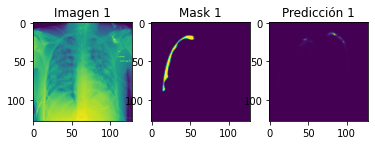

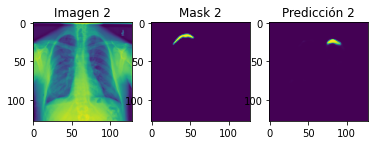

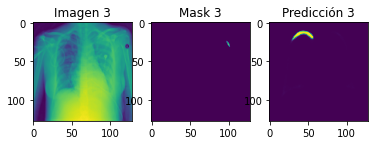

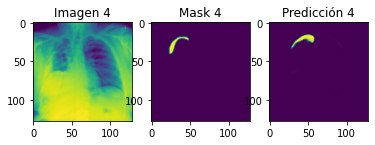

In [ ]:
for idx in range(4):
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
  ax1.imshow(datagen_test1[0][0][idx].reshape(128,128))
  ax1.set_title(f'Imagen {idx+1}')
  ax2.imshow(datagen_test1[0][1][idx].reshape(128,128))
  ax2.set_title(f'Mask {idx+1}')
  ax3.imshow(preds1[idx].reshape(128,128))
  ax3.set_title(f'Predicción {idx+1}')

#### Modelo 2: BS=64; StartChannel=32; Depth=3; BatchNorm=False; Residual=True; Dropout=False; Epochs=20


In [ ]:
datagen2 = DataGenerator(
    'siim-acr-pneumothorax/',
    filenames_train,
    "png_images/",
    "png_masks/",
    transform = False,
    batch_size = 64,  
)

In [ ]:
datagen_val2 = DataGenerator(
    'siim-acr-pneumothorax/',
    filenames_val,
    "png_images/",
    "png_masks/",
    transform = False,
    batch_size = 64,   
)

In [ ]:
datagen_test2 = DataGenerator(
    'siim-acr-pneumothorax/',
    filenames_test,
    "png_images/",
    "png_masks/",
    transform = False,
    batch_size = 64,   
)

In [ ]:
model2 = UNet((128,128,1),start_ch=32,depth=3,batchnorm=False, residual = True,dropout=False)
model2.compile(loss=dice_coef_loss, optimizer="adam", metrics=["binary_crossentropy", dice_coef])

In [ ]:
model2.fit(datagen2, epochs = 50, validation_data=datagen_val2)

Epoch 1/50
29/29 [==============================] - 45s 1s/step - loss: 0.5631 - binary_crossentropy: 0.1428 - dice_coef: 0.0166
Epoch 2/50
29/29 [==============================] - 44s 2s/step - loss: 0.5100 - binary_crossentropy: 0.0725 - dice_coef: 0.0525
Epoch 3/50
29/29 [==============================] - 43s 1s/step - loss: 0.4893 - binary_crossentropy: 0.0770 - dice_coef: 0.0983
Epoch 4/50
29/29 [==============================] - 44s 1s/step - loss: 0.4634 - binary_crossentropy: 0.0857 - dice_coef: 0.1588
Epoch 5/50
29/29 [==============================] - 44s 1s/step - loss: 0.4386 - binary_crossentropy: 0.0851 - dice_coef: 0.2079
Epoch 6/50
29/29 [==============================] - 45s 2s/step - loss: 0.4249 - binary_crossentropy: 0.0859 - dice_coef: 0.2361
Epoch 7/50
29/29 [==============================] - 44s 1s/step - loss: 0.4093 - binary_crossentropy: 0.0812 - dice_coef: 0.2626
Epoch 8/50
29/29 [==============================] - 44s 1s/step - loss: 0.4061 - binary_crossentr

In [ ]:
Dice_train2 = model2.history.history['dice_coef']

In [ ]:
metricas2 = model2.evaluate(datagen_test2,return_dict=True)

4/4 [==============================] - 6s 1s/step - loss: 0.3576 - binary_crossentropy: 0.0878 - dice_coef: 0.3727


In [ ]:
preds2 = model2.predict(datagen_test2)

4/4 [==============================] - 6s 1s/step


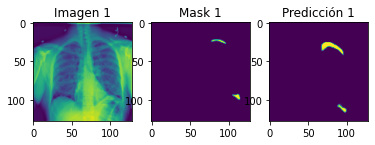

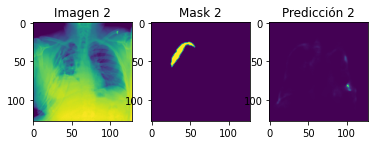

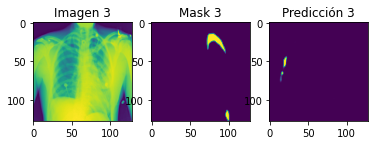

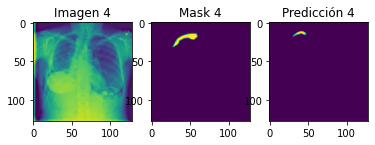

In [ ]:
for idx in range(4):
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
  ax1.imshow(datagen_test2[0][0][idx].reshape(128,128))
  ax1.set_title(f'Imagen {idx+1}')
  ax2.imshow(datagen_test2[0][1][idx].reshape(128,128))
  ax2.set_title(f'Mask {idx+1}')
  ax3.imshow(preds2[idx].reshape(128,128))
  ax3.set_title(f'Predicción {idx+1}')

#### Modelo 3: BS=64; StartChannel=32; Depth=3; BatchNorm=True; Residual=True; Dropout=False; Epochs=20


In [ ]:
datagen3 = DataGenerator(
    'siim-acr-pneumothorax/',
    filenames_train,
    "png_images/",
    "png_masks/",
    transform = False,
    batch_size = 64,  
)

In [ ]:
datagen_val3 = DataGenerator(
    'siim-acr-pneumothorax/',
    filenames_val,
    "png_images/",
    "png_masks/",
    transform = False,
    batch_size = 64,   
)

In [ ]:
datagen_test3 = DataGenerator(
    'siim-acr-pneumothorax/',
    filenames_test,
    "png_images/",
    "png_masks/",
    transform = False,
    batch_size = 64,   
)

In [ ]:
model3 = UNet((128,128,1),start_ch=32,depth=3,batchnorm=True, residual = True,dropout=False)
model3.compile(loss=dice_coef_loss, optimizer="adam", metrics=["binary_crossentropy", dice_coef])

In [ ]:
model3.fit(datagen3, epochs = 20, validation_data=datagen_val3)

Epoch 1/20
29/29 [==============================] - 53s 2s/step - loss: 0.5128 - binary_crossentropy: 0.1624 - dice_coef: 0.1368
Epoch 2/20
29/29 [==============================] - 46s 2s/step - loss: 0.4076 - binary_crossentropy: 0.0841 - dice_coef: 0.2689
Epoch 3/20
29/29 [==============================] - 44s 2s/step - loss: 0.3840 - binary_crossentropy: 0.0781 - dice_coef: 0.3100
Epoch 4/20
29/29 [==============================] - 44s 1s/step - loss: 0.3691 - binary_crossentropy: 0.0749 - dice_coef: 0.3367
Epoch 5/20
29/29 [==============================] - 44s 2s/step - loss: 0.3573 - binary_crossentropy: 0.0742 - dice_coef: 0.3596
Epoch 6/20
29/29 [==============================] - 44s 1s/step - loss: 0.3512 - binary_crossentropy: 0.0726 - dice_coef: 0.3702
Epoch 7/20
29/29 [==============================] - 44s 1s/step - loss: 0.3395 - binary_crossentropy: 0.0712 - dice_coef: 0.3921
Epoch 8/20
29/29 [==============================] - 44s 1s/step - loss: 0.3305 - binary_crossentr

In [ ]:
Dice_train3 = model3.history.history['dice_coef']

In [ ]:
metricas3 = model3.evaluate(datagen_test3,return_dict=True)

4/4 [==============================] - 10s 970ms/step - loss: 0.3709 - binary_crossentropy: 0.0836 - dice_coef: 0.3417


In [ ]:
preds3 = model3.predict(datagen_test3)

4/4 [==============================] - 6s 1s/step


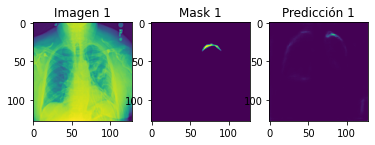

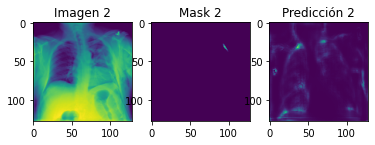

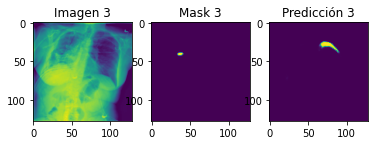

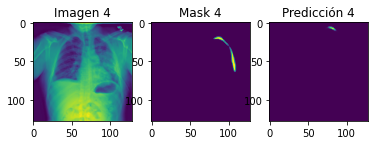

In [ ]:
for idx in range(4):
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
  ax1.imshow(datagen_test3[0][0][idx].reshape(128,128))
  ax1.set_title(f'Imagen {idx+1}')
  ax2.imshow(datagen_test3[0][1][idx].reshape(128,128))
  ax2.set_title(f'Mask {idx+1}')
  ax3.imshow(preds3[idx].reshape(128,128))
  ax3.set_title(f'Predicción {idx+1}')

#### Modelo 4: BS=64; StartChannel=32; Depth=5; BatchNorm=False; Residual=True; Dropout=False; Epochs=20


In [ ]:
datagen4 = DataGenerator(
    'siim-acr-pneumothorax/',
    filenames_train,
    "png_images/",
    "png_masks/",
    transform = False,
    batch_size = 64,  
)

In [ ]:
datagen_val4 = DataGenerator(
    'siim-acr-pneumothorax/',
    filenames_val,
    "png_images/",
    "png_masks/",
    transform = False,
    batch_size = 64,   
)

In [ ]:
datagen_test4 = DataGenerator(
    'siim-acr-pneumothorax/',
    filenames_test,
    "png_images/",
    "png_masks/",
    transform = False,
    batch_size = 64,   
)

In [ ]:
model4 = UNet((128,128,1),start_ch=32,depth=5,batchnorm=True, residual = True,dropout=False)
model4.compile(loss=dice_coef_loss, optimizer="adam", metrics=["binary_crossentropy", dice_coef])

In [ ]:
model4.fit(datagen4, epochs = 20, validation_data=datagen_val4)

Epoch 1/20
29/29 [==============================] - 58s 2s/step - loss: 0.4753 - binary_crossentropy: 0.1215 - dice_coef: 0.1709
Epoch 2/20
29/29 [==============================] - 46s 2s/step - loss: 0.4007 - binary_crossentropy: 0.0829 - dice_coef: 0.2815
Epoch 3/20
29/29 [==============================] - 48s 2s/step - loss: 0.3768 - binary_crossentropy: 0.0785 - dice_coef: 0.3249
Epoch 4/20
29/29 [==============================] - 46s 2s/step - loss: 0.3529 - binary_crossentropy: 0.0753 - dice_coef: 0.3695
Epoch 5/20
29/29 [==============================] - 46s 2s/step - loss: 0.3416 - binary_crossentropy: 0.0714 - dice_coef: 0.3882
Epoch 6/20
29/29 [==============================] - 46s 2s/step - loss: 0.3387 - binary_crossentropy: 0.0721 - dice_coef: 0.3947
Epoch 7/20
29/29 [==============================] - 46s 2s/step - loss: 0.3234 - binary_crossentropy: 0.0689 - dice_coef: 0.4220
Epoch 8/20
29/29 [==============================] - 46s 2s/step - loss: 0.3062 - binary_crossentr

In [ ]:
Dice_train4 = model4.history.history['dice_coef']

In [ ]:
metricas4 = model4.evaluate(datagen_test4,return_dict=True)

4/4 [==============================] - 15s 2s/step - loss: 0.4042 - binary_crossentropy: 0.0818 - dice_coef: 0.2735


In [ ]:
preds4 = model4.predict(datagen_test4)

4/4 [==============================] - 6s 1s/step


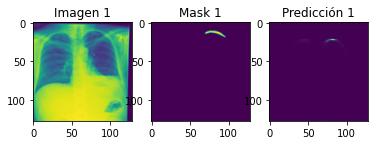

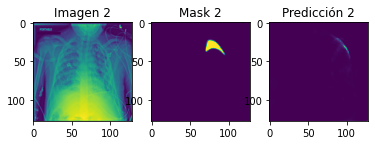

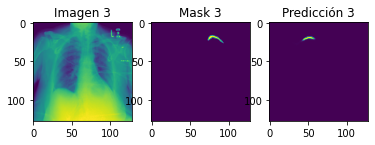

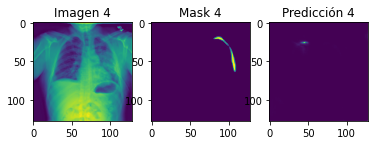

In [ ]:
for idx in range(4):
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
  ax1.imshow(datagen_test4[0][0][idx].reshape(128,128))
  ax1.set_title(f'Imagen {idx+1}')
  ax2.imshow(datagen_test4[0][1][idx].reshape(128,128))
  ax2.set_title(f'Mask {idx+1}')
  ax3.imshow(preds4[idx].reshape(128,128))
  ax3.set_title(f'Predicción {idx+1}')

#### Modelo 5: BS=128; StartChannel=32; Depth=3; BatchNorm=False; Residual=True; Dropout=False; Epochs=20

In [ ]:
datagen5 = DataGenerator(
    'siim-acr-pneumothorax/',
    filenames_train,
    "png_images/",
    "png_masks/",
    transform = False,
    batch_size = 128,  
)

In [ ]:
datagen_val5 = DataGenerator(
    'siim-acr-pneumothorax/',
    filenames_val,
    "png_images/",
    "png_masks/",
    transform = False,
    batch_size = 128,   
)

In [ ]:
datagen_test5 = DataGenerator(
    'siim-acr-pneumothorax/',
    filenames_test,
    "png_images/",
    "png_masks/",
    transform = False,
    batch_size = 128,   
)

In [ ]:
model5 = UNet((128,128,1),start_ch=32,depth=3,batchnorm=False, residual = True,dropout=False)
model5.compile(loss=dice_coef_loss, optimizer="adam", metrics=["binary_crossentropy", dice_coef])

In [ ]:
model5.fit(datagen5, epochs = 20, validation_data=datagen_val5)

Epoch 1/20
14/14 [==============================] - 107s 3s/step - loss: 0.5931 - binary_crossentropy: 0.1979 - dice_coef: 0.0117
Epoch 2/20
14/14 [==============================] - 43s 3s/step - loss: 0.5261 - binary_crossentropy: 0.0770 - dice_coef: 0.0249
Epoch 3/20
14/14 [==============================] - 43s 3s/step - loss: 0.5113 - binary_crossentropy: 0.0712 - dice_coef: 0.0486
Epoch 4/20
14/14 [==============================] - 44s 3s/step - loss: 0.4992 - binary_crossentropy: 0.0807 - dice_coef: 0.0823
Epoch 5/20
14/14 [==============================] - 44s 3s/step - loss: 0.4904 - binary_crossentropy: 0.0805 - dice_coef: 0.0996
Epoch 6/20
14/14 [==============================] - 43s 3s/step - loss: 0.4803 - binary_crossentropy: 0.0780 - dice_coef: 0.1174
Epoch 7/20
14/14 [==============================] - 46s 3s/step - loss: 0.4752 - binary_crossentropy: 0.0908 - dice_coef: 0.1404
Epoch 8/20
14/14 [==============================] - 44s 3s/step - loss: 0.4511 - binary_crossent

In [ ]:
Dice_train5 = model5.history.history['dice_coef']

In [ ]:
metricas5 = model5.evaluate(datagen_test5,return_dict=True)

2/2 [==============================] - 6s 3s/step - loss: 0.3675 - binary_crossentropy: 0.0637 - dice_coef: 0.3287


In [ ]:
preds5 = model5.predict(datagen_test5)

2/2 [==============================] - 6s 3s/step


In [ ]:
len(preds5)

256

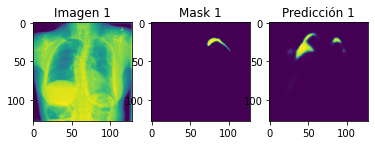

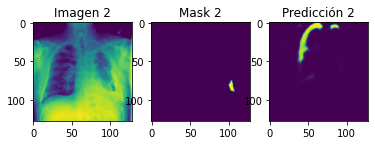

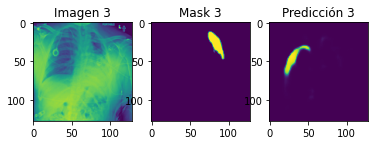

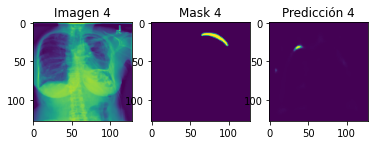

In [ ]:
for idx in range(4):
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
  ax1.imshow(datagen_test5[0][0][idx].reshape(128,128))
  ax1.set_title(f'Imagen {idx+1}')
  ax2.imshow(datagen_test5[0][1][idx].reshape(128,128))
  ax2.set_title(f'Mask {idx+1}')
  ax3.imshow(preds5[idx].reshape(128,128))
  ax3.set_title(f'Predicción {idx+1}')

### Modelos con transform

#### Modelo 5: BS=64; StartChannel=32; Depth=3; BatchNorm=False; Residual=True; Dropout=False; Epochs=20

In [ ]:
datagen6 = DataGenerator(
    'siim-acr-pneumothorax/',
    filenames_train,
    "png_images/",
    "png_masks/",
    transform = True,
    batch_size = 64,  
)

In [ ]:
datagen_val6 = DataGenerator(
    'siim-acr-pneumothorax/',
    filenames_val,
    "png_images/",
    "png_masks/",
    transform = False,
    batch_size = 64,   
)

In [ ]:
datagen_test6 = DataGenerator(
    'siim-acr-pneumothorax/',
    filenames_test,
    "png_images/",
    "png_masks/",
    transform = False,
    batch_size = 64,   
)

In [ ]:
model6 = UNet((128,128,1),start_ch=32,depth=3,batchnorm=False, residual = True,dropout=False)
model6.compile(loss=dice_coef_loss, optimizer="adam", metrics=["binary_crossentropy", dice_coef])

In [ ]:
model6.fit(datagen6, epochs = 20, validation_data=datagen_val6)

Epoch 1/20
29/29 [==============================] - 45s 1s/step - loss: 0.5554 - binary_crossentropy: 0.1285 - dice_coef: 0.0177
Epoch 2/20
29/29 [==============================] - 45s 2s/step - loss: 0.5184 - binary_crossentropy: 0.0724 - dice_coef: 0.0356
Epoch 3/20
29/29 [==============================] - 44s 1s/step - loss: 0.5129 - binary_crossentropy: 0.0754 - dice_coef: 0.0496
Epoch 4/20
29/29 [==============================] - 43s 1s/step - loss: 0.5050 - binary_crossentropy: 0.0791 - dice_coef: 0.0691
Epoch 5/20
29/29 [==============================] - 43s 1s/step - loss: 0.4946 - binary_crossentropy: 0.0817 - dice_coef: 0.0926
Epoch 6/20
29/29 [==============================] - 43s 1s/step - loss: 0.4904 - binary_crossentropy: 0.0876 - dice_coef: 0.1067
Epoch 7/20
29/29 [==============================] - 43s 1s/step - loss: 0.4856 - binary_crossentropy: 0.0835 - dice_coef: 0.1123
Epoch 8/20
29/29 [==============================] - 43s 1s/step - loss: 0.4680 - binary_crossentr

In [ ]:
Dice_train6 = model6.history.history['dice_coef']

In [ ]:
metricas6 = model6.evaluate(datagen_test6,return_dict=True)

4/4 [==============================] - 7s 2s/step - loss: 0.3865 - binary_crossentropy: 0.0690 - dice_coef: 0.2959


In [ ]:
preds6 = model6.predict(datagen_test6)

4/4 [==============================] - 7s 2s/step


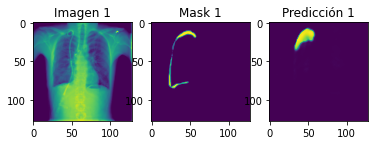

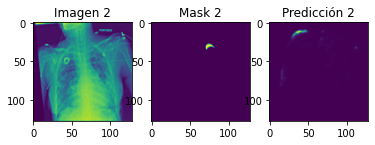

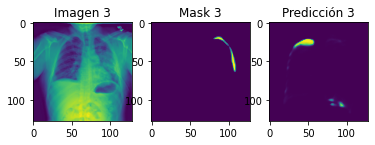

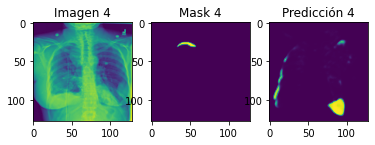

In [ ]:
for idx in range(4):
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
  ax1.imshow(datagen_test6[0][0][idx].reshape(128,128))
  ax1.set_title(f'Imagen {idx+1}')
  ax2.imshow(datagen_test6[0][1][idx].reshape(128,128))
  ax2.set_title(f'Mask {idx+1}')
  ax3.imshow(preds6[idx].reshape(128,128))
  ax3.set_title(f'Predicción {idx+1}')

#### Modelo 7: BS = 128; StartChannel=32; Depth=5; BatchNorm=False; Residual=True; Dropout=False; Epochs=20


In [ ]:
datagen7 = DataGenerator(
    'siim-acr-pneumothorax/',
    filenames_train,
    "png_images/",
    "png_masks/",
    transform = True,
    batch_size = 128,  
)

In [ ]:
datagen_val7 = DataGenerator(
    'siim-acr-pneumothorax/',
    filenames_val,
    "png_images/",
    "png_masks/",
    transform = False,
    batch_size = 128,   
)

In [ ]:
datagen_test7 = DataGenerator(
    'siim-acr-pneumothorax/',
    filenames_test,
    "png_images/",
    "png_masks/",
    transform = False,
    batch_size = 128,   
)

In [ ]:
model7 = UNet((128,128,1),start_ch=32,depth=3,batchnorm=False, residual = True,dropout=False)
model7.compile(loss=dice_coef_loss, optimizer="adam", metrics=["binary_crossentropy", dice_coef])

In [ ]:
model7.fit(datagen7, epochs = 20, validation_data=datagen_val7)

Epoch 1/20
14/14 [==============================] - 59s 3s/step - loss: 0.6015 - binary_crossentropy: 0.2147 - dice_coef: 0.0116
Epoch 2/20
14/14 [==============================] - 45s 3s/step - loss: 0.5242 - binary_crossentropy: 0.0741 - dice_coef: 0.0258
Epoch 3/20
14/14 [==============================] - 44s 3s/step - loss: 0.5189 - binary_crossentropy: 0.0711 - dice_coef: 0.0332
Epoch 4/20
14/14 [==============================] - 46s 3s/step - loss: 0.5146 - binary_crossentropy: 0.0748 - dice_coef: 0.0455
Epoch 5/20
14/14 [==============================] - 46s 3s/step - loss: 0.5124 - binary_crossentropy: 0.0771 - dice_coef: 0.0524
Epoch 6/20
14/14 [==============================] - 45s 3s/step - loss: 0.5074 - binary_crossentropy: 0.0747 - dice_coef: 0.0599
Epoch 7/20
14/14 [==============================] - 44s 3s/step - loss: 0.5033 - binary_crossentropy: 0.0754 - dice_coef: 0.0688
Epoch 8/20
14/14 [==============================] - 45s 3s/step - loss: 0.4964 - binary_crossentr

In [ ]:
Dice_train7 = model7.history.history['dice_coef']

In [ ]:
metricas7 = model7.evaluate(datagen_test7,return_dict=True)

2/2 [==============================] - 6s 3s/step - loss: 0.4011 - binary_crossentropy: 0.0767 - dice_coef: 0.2746


In [ ]:
preds7 = model7.predict(datagen_test7)

2/2 [==============================] - 7s 3s/step


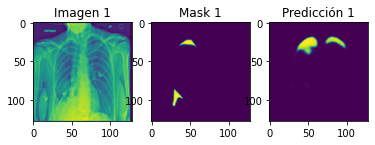

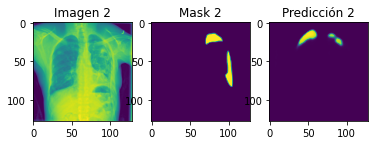

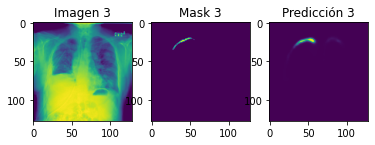

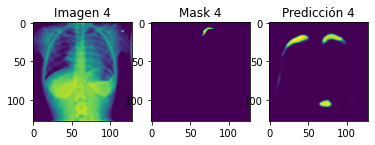

In [ ]:
for idx in range(4):
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
  ax1.imshow(datagen_test7[0][0][idx].reshape(128,128))
  ax1.set_title(f'Imagen {idx+1}')
  ax2.imshow(datagen_test7[0][1][idx].reshape(128,128))
  ax2.set_title(f'Mask {idx+1}')
  ax3.imshow(preds7[idx].reshape(128,128))
  ax3.set_title(f'Predicción {idx+1}')

### Conclusiones


Se probaron varios modelos. Los mejores resultados se obtuvieron sin aplicar transformaciones de data augmentation a las imágenes. Además, el batch size que dio mejores resultados fue de 64 imágenes sin batch normalization (Modelo 2).

Se probó con 50 epochs y se obtuvo un índice de Dice de 0.73 en train y 0.37 en test, por lo cual se presenta un sobreajuste a los datos de entrenamiento. Las predicciones difieren mucho de la imagen original en algunos casos, y en otros se acercan bastante al ground truth.

Para obtener mejores resultados, deberían probarse muchos más modelos. No creo que con los parámetros utilizados en las pruebas, los resultados mejoren al entrenar más épocas. Esto es porque como se ve en varios modelos, el índice de Dice mejora en train con las épocas pero no lo hace en test.